In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd '/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)'

/content/drive/MyDrive/MIDS/DATASCI 281 Summer 2025/datasci281_final_project (github)


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2 as cv
from skimage.feature import hog
from skimage.feature import blob_log, blob_dog, blob_doh
from skimage import data, exposure
from utils import *
from skimage.filters import difference_of_gaussians
from skimage.filters import laplace
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error
from scipy import stats
from skimage.feature import hessian_matrix, hessian_matrix_det

In [4]:
# Setup Data Paths
cwd = os.getcwd()
data_path = os.path.join(cwd,'standardized_data')
training_path = os.path.join(data_path,'Training')

# Initialize Data Variables
X_train = []
Y_train = []
image_file_names = []

# Load in Images and Labels
for label in os.listdir(training_path):
    label_path = os.path.join(training_path,label)
    for image in os.listdir(label_path):
        image_file_names.append(image)
        image_path = os.path.join(label_path,image)
        img_array = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        X_train.append(img_array)
        Y_train.append(label)

# Shuffle Data for Randomization
np.random.seed(281)
indices = [i for i in range(0,len(X_train))]
shuffle_indices = np.random.permutation(indices)
X_train_shuffled = [X_train[i] for i in shuffle_indices]
Y_train_shuffled = [Y_train[i] for i in shuffle_indices]

### 4. Blobs and Edges

In [5]:
np.random.seed(281)
random_indices = np.random.choice(len(X_train), 10, replace=False)

HOG (Histogram of Gradients)

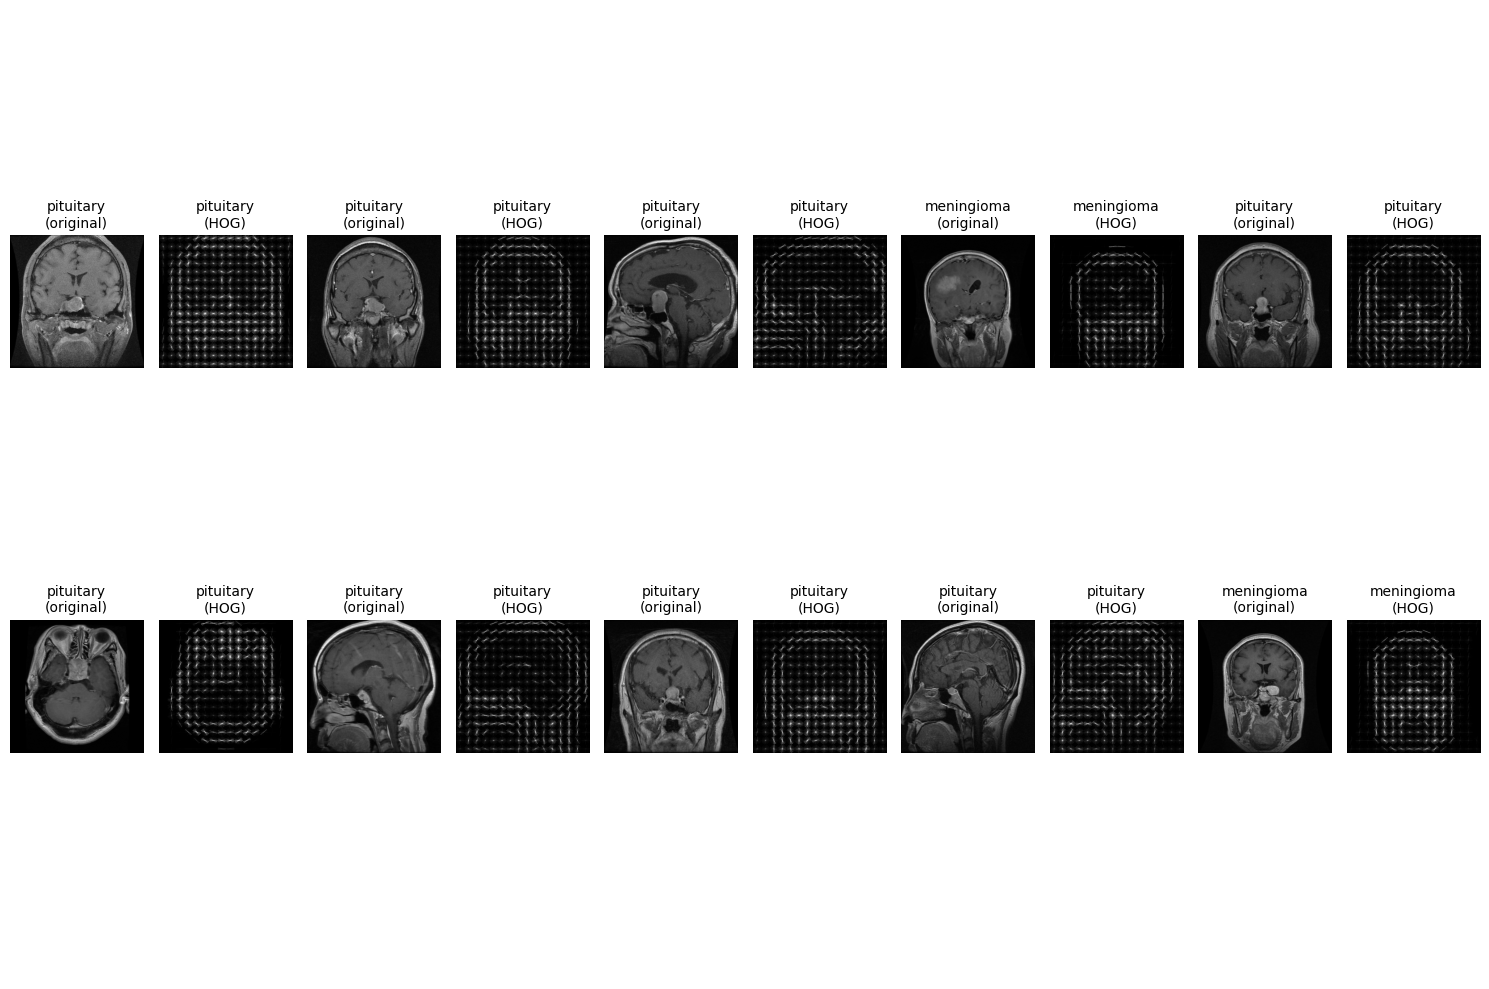

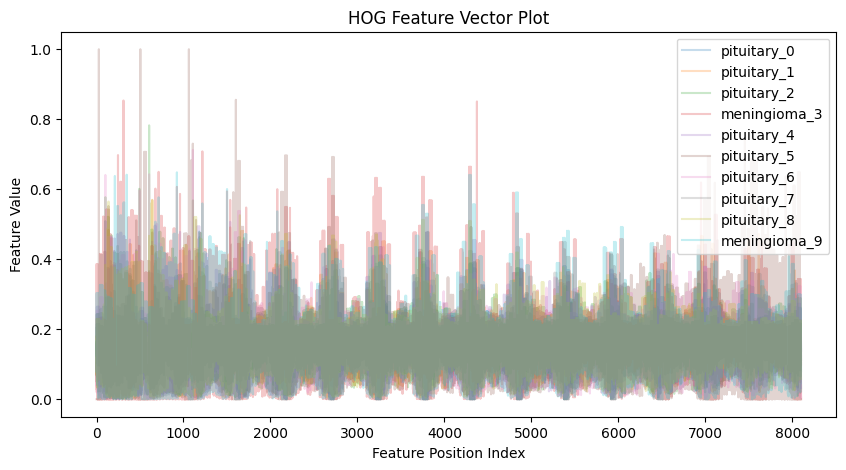

In [6]:
# Plot HOG for 10 random images
plt.figure(figsize=(15, 10))
plt.axis('off')

select_features = []
select_labels = []

for i, index in enumerate(random_indices):
  image = X_train[index]
  label = Y_train[index]
  select_labels.append(label)

  fd, hog_image = hog(image, orientations=9, pixels_per_cell=(32, 32),
                      cells_per_block=(2, 2), visualize=True)

  select_features.append(fd)

  # Rescale histogram for better display
  hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 3))

  plt.subplot(2, 10, i + i + 1)
  plt.title(f'{label}\n(original)', fontsize=10)
  plt.axis('off')
  plt.imshow(image, cmap="gray")
  plt.subplot(2, 10, i + i + 2)
  plt.title(f'{label}\n(HOG)', fontsize=10)
  plt.axis('off')
  plt.imshow(hog_image_rescaled, cmap="gray")

plt.tight_layout()
plt.show()


# plot HOG feature vectors
plt.figure(figsize=(10, 5))
for f in select_features:
  plt.plot(f, alpha=0.25)
plt.title("HOG Feature Vector Plot")
plt.xlabel("Feature Position Index")
plt.ylabel("Feature Value")
plt.legend(['{}_{}'.format(select_labels[i],i) for i in range(len(select_labels))])
plt.show()

Difference of Gaussians (DoG)

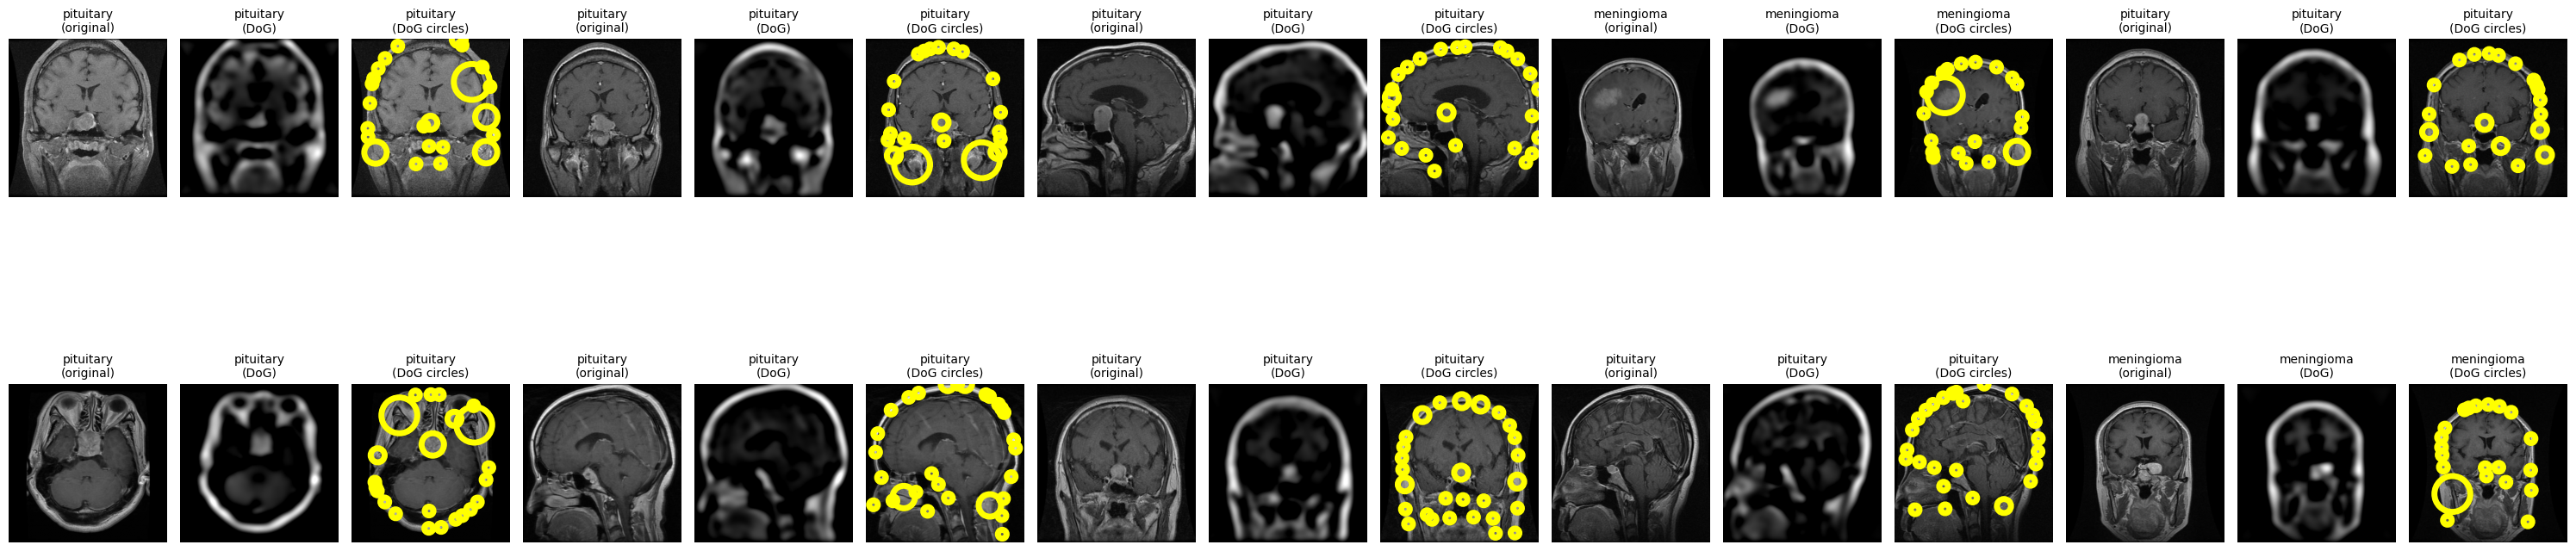

In [19]:
fig, ax = plt.subplots(2, 15, figsize=(30, 10))

ax_idx = 0

for i, index in enumerate(random_indices):
  image = X_train[index]
  label = Y_train[index]

  dog_image = difference_of_gaussians(image, 10, 50)
  # Rescale for better display
  dog_image_rescaled = exposure.rescale_intensity(dog_image, in_range=(0, 0.3))

  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(original)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(image, cmap="gray")
  ax_idx += 1
  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(DoG)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(dog_image_rescaled, cmap="gray")
  ax_idx += 1

  blobs_dog = blob_dog(image, min_sigma=10, max_sigma=50, threshold=0.08)
  blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(DoG circles)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(image, cmap="gray")
  if blobs_dog.shape[0] > 0:
    for blob in blobs_dog:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='yellow', linewidth=5, fill=False)
      ax[ax_idx//15,ax_idx%15].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Laplacian of Guassian (LoG)

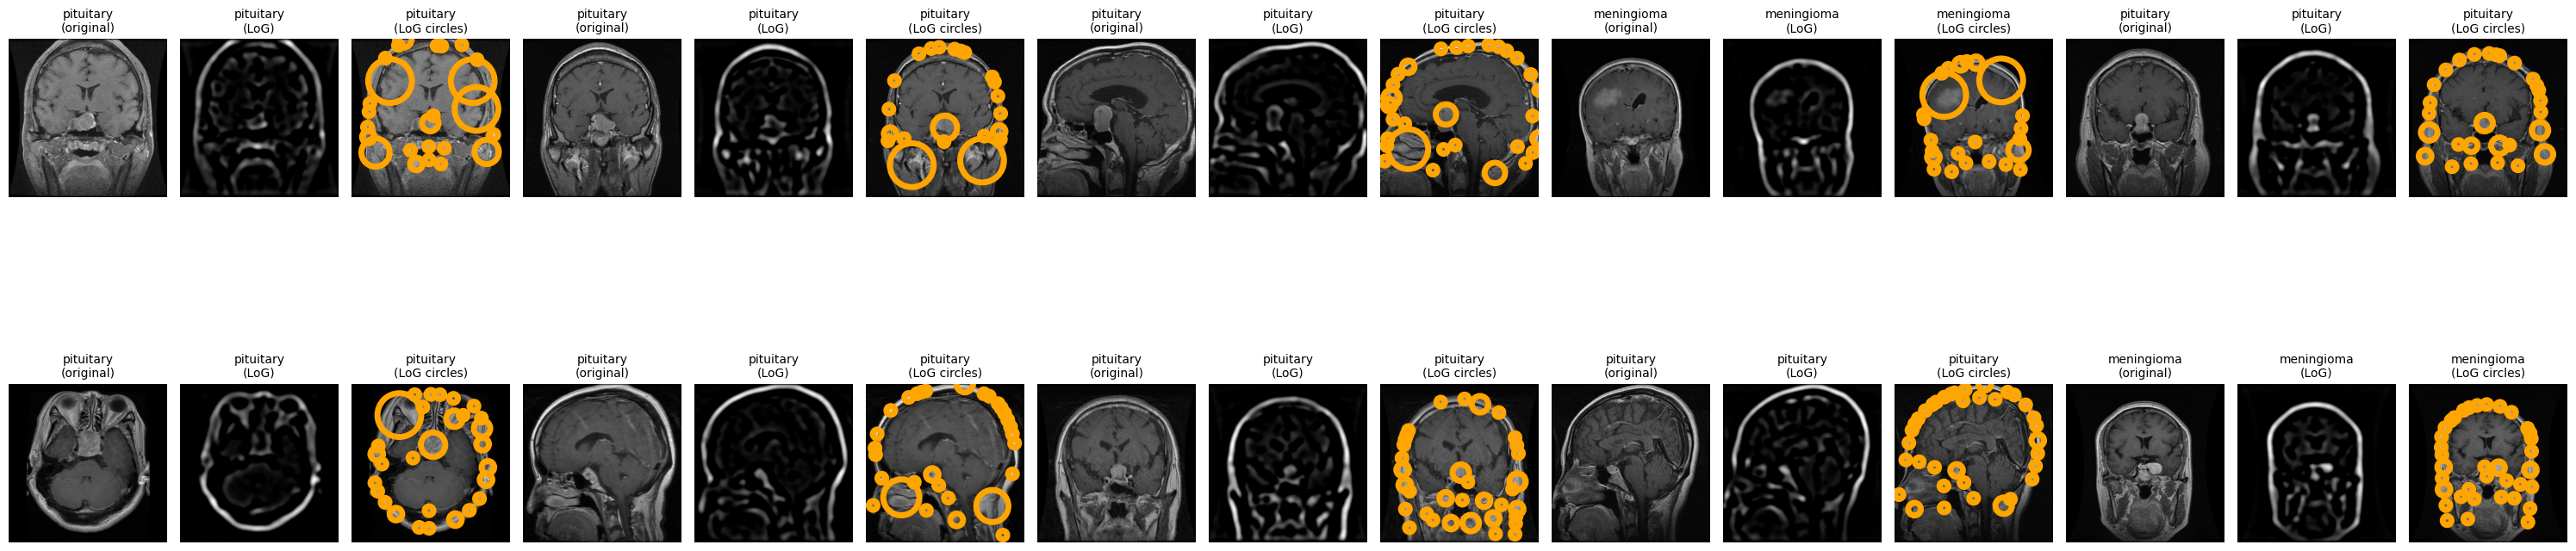

In [27]:
fig, ax = plt.subplots(2, 15, figsize=(30, 10))

ax_idx = 0

for i, index in enumerate(random_indices):
  image = X_train[index]
  label = Y_train[index]

  # Apply Gaussian blur
  blurred_image = gaussian(image, sigma=10)

  # Apply Laplacian filter
  log_image = laplace(blurred_image)
  # Rescale for better display
  log_image_rescaled = exposure.rescale_intensity(log_image, in_range=(0, 0.05))

  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(original)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(image, cmap="gray")
  ax_idx += 1
  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(LoG)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(log_image_rescaled, cmap="gray")
  ax_idx += 1

  blobs_log = blob_log(image, min_sigma=10, max_sigma=50, threshold=0.1)
  blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(LoG circles)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(image, cmap="gray")
  if blobs_log.shape[0] > 0:
    for blob in blobs_log:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='orange', linewidth=5, fill=False)
      ax[ax_idx//15,ax_idx%15].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Determinant of Hessian (DoH)

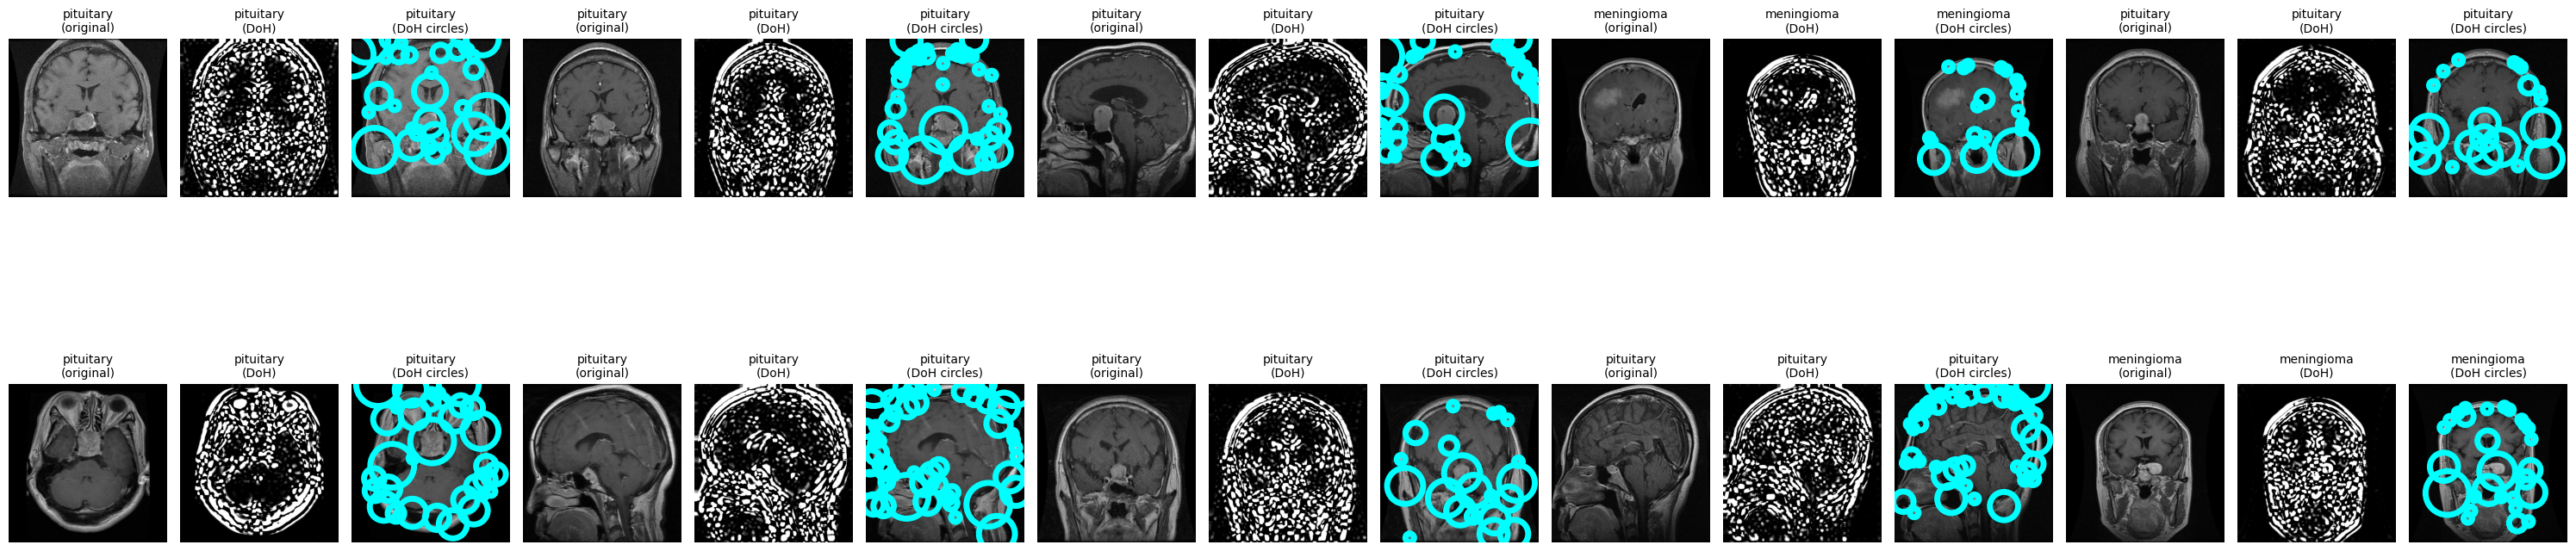

In [40]:
fig, ax = plt.subplots(2, 15, figsize=(30, 10))

ax_idx = 0

for i, index in enumerate(random_indices):
  image = X_train[index]
  label = Y_train[index]

  # Calculate Hessian matrix determinant
  hessian_det_image = hessian_matrix_det(image, sigma=10) # You may need to tune sigma
  # Rescale for better display
  hessian_det_image_rescaled = exposure.rescale_intensity(hessian_det_image, in_range=(0, 0.0001))

  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(original)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(image, cmap="gray")
  ax_idx += 1
  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(DoH)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(hessian_det_image_rescaled, cmap="gray")
  ax_idx += 1

  blobs_doh = blob_doh(image, min_sigma=10, max_sigma=50, threshold=0.002)
  blobs_doh[:, 2] = blobs_doh[:, 2] * np.sqrt(2)

  ax[ax_idx//15,ax_idx%15].set_title(f'{label}\n(DoH circles)', fontsize=10)
  ax[ax_idx//15,ax_idx%15].set_axis_off()
  ax[ax_idx//15,ax_idx%15].imshow(image, cmap="gray")
  if blobs_doh.shape[0] > 0:
    for blob in blobs_doh:
      y, x, r = blob
      c = plt.Circle((x, y), r, color='cyan', linewidth=5, fill=False)
      ax[ax_idx//15,ax_idx%15].add_patch(c)
  ax_idx += 1

plt.tight_layout()
plt.show()

Canny Edges

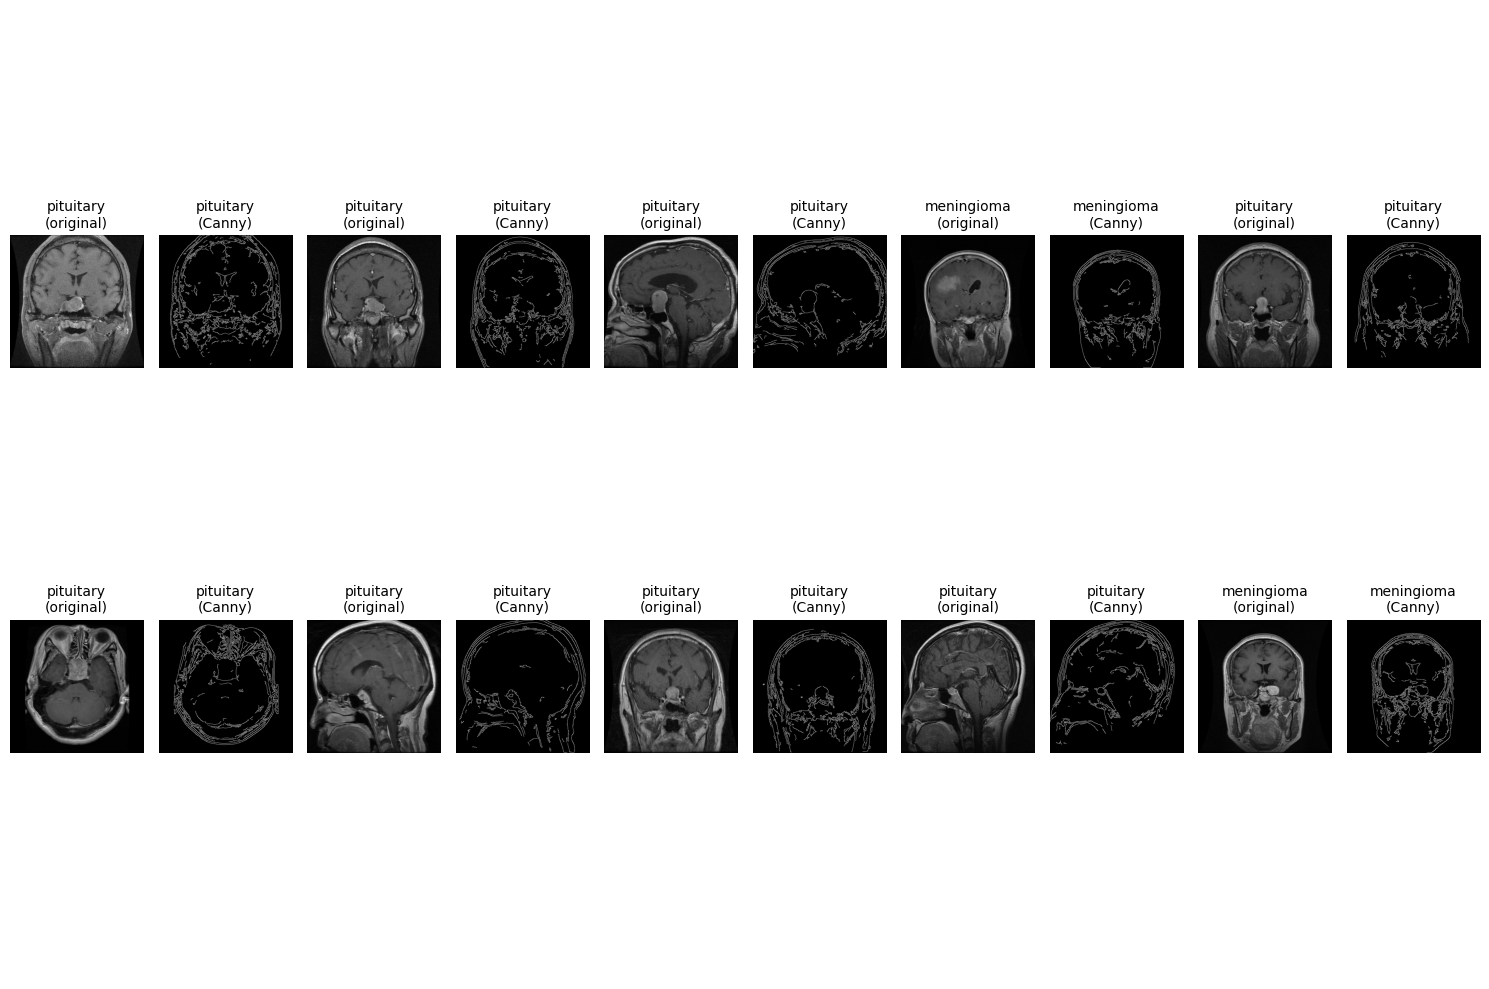

In [44]:
plt.figure(figsize=(15, 10))
plt.axis('off')

for i, index in enumerate(random_indices):
  image = X_train[index]
  label = Y_train[index]

  # Apply Canny edge detection
  canny_image = cv.Canny(image, 100, 200)  # You may need to tune the thresholds
  # Rescale for better display
  canny_image_rescaled = exposure.rescale_intensity(canny_image, in_range=(0, 0.000001))

  plt.subplot(2, 10, i + i + 1)
  plt.title(f'{label}\n(original)', fontsize=10)
  plt.axis('off')
  plt.imshow(image, cmap="gray")
  plt.subplot(2, 10, i + i + 2)
  plt.title(f'{label}\n(Canny)', fontsize=10)
  plt.axis('off')
  plt.imshow(canny_image_rescaled, cmap="gray")

plt.tight_layout()
plt.show()